In [14]:
!pip install -q condacolab
import condacolab
condacolab.install()

⏬ Downloading https://github.com/jaimergp/miniforge/releases/download/24.11.2-1_colab/Miniforge3-colab-24.11.2-1_colab-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:14
🔁 Restarting kernel...


In [1]:
!wget https://cs.stanford.edu/~minalee/zip/chi2022-coauthor-v1.0.zip
!unzip -q chi2022-coauthor-v1.0.zip
!rm chi2022-coauthor-v1.0.zip
!unzip -q creativity_index-main.zip

--2025-02-25 20:17:19--  https://cs.stanford.edu/~minalee/zip/chi2022-coauthor-v1.0.zip
Resolving cs.stanford.edu (cs.stanford.edu)... 171.64.64.64
Connecting to cs.stanford.edu (cs.stanford.edu)|171.64.64.64|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 49956179 (48M) [application/zip]
Saving to: ‘chi2022-coauthor-v1.0.zip’

chi2022-coauthor-v1 100%[===================>]  47.64M  2.22MB/s    in 17s     

2025-02-25 20:17:36 (2.88 MB/s) - ‘chi2022-coauthor-v1.0.zip’ saved [49956179/49956179]

replace coauthor-v1.0/e0435f4cf6fc435c872ffc5b66b66b0c.jsonl? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [3]:
!unzip -q creativity_index-main.zip

Coauthor cleanup

In [4]:
import os

dataset_dir = './coauthor-v1.0'
paths = [
    os.path.join(dataset_dir, path)
    for path in os.listdir(dataset_dir)
    if path.endswith('jsonl')
]

print(f'Successfully downloaded {len(paths)} writing sessions in CoAuthor!')

Successfully downloaded 1447 writing sessions in CoAuthor!


In [5]:
import json

def read_writing_session(path):
    events = []
    with open(path, 'r') as f:
        for event in f:
            events.append(json.loads(event))
    print(f'Successfully read {len(events)} events in a writing session from {path}')
    return events

In [6]:
events = read_writing_session(paths[0])

Successfully read 1238 events in a writing session from ./coauthor-v1.0/9614fb65fa5146549e303e13586a947b.jsonl


In [7]:
from collections import defaultdict

def reconstruct_user_text(events):
    user_texts = []
    current_text = ""

    # Sort events by eventNum
    sorted_events = sorted(events, key=lambda e: e["eventNum"])

    for event in sorted_events:
        event_type = event["eventName"]
        text_delta = event["textDelta"]

        if event_type == "text-insert" and text_delta:
            extracted_text = ""
            for op in text_delta['ops']:
                if 'insert' in op:
                    extracted_text += op['insert']
            current_text += extracted_text

        elif event_type == "text-delete" and text_delta:
            delete_len = 0
            for op in text_delta['ops']:
                if 'delete' in op:
                    delete_len += op['delete']
                elif 'retain' in op:
                    pass
            current_text = current_text[:-delete_len]


        # Store finalized text if user completes a thought
        if event_type == "suggestion-get" or event_type == "suggestion-select":
            if current_text.strip():
                user_texts.append(current_text.strip())
                current_text = ""

    return user_texts

# Process all valid events
user_texts = reconstruct_user_text(events)

print(f"Total reconstructed user-written sentences: {len(user_texts)}")
print("Example user-written sentence:", user_texts)  # Show first 3 examples

Total reconstructed user-written sentences: 3
Example user-written sentence: ['college athletes should be paid over and above their scholorships.aThey should be paid a percentage of ticket sales. I do not agree that the broader community would be harmed. This is real life. Times change. It is fair that if the college makes a great sum of income, that some of it go to the players. Colleges in bidding wars? They do that anyway, but without money. They bid for the best. The athletes would receive no compensation until they graduate, again, which would be a percentage of tickets sold. \n\nIf colleges did not profit on their athletes, then no, they should not be paid. I think this is the best solution of all. This way, anyone can go to a game that they might not have otherwise been able to afford.', 'Having good sports is a boon to the colleges. They get televised or broadcasted which increases brand awareness. There are some thin, creating good will in the community.s that are hard to meas

In [8]:
def extract_selected_ai_suggestions(events):
    ai_suggestions = []  # Stores accepted AI-generated suggestions
    last_suggestion_open = None  # Store the most recent `suggestion-open` event

    for event in events:
        if event["eventName"] == "suggestion-open" and event.get("currentSuggestions"):
            last_suggestion_open = event  # Save latest `suggestion-open` event

        elif event["eventName"] == "suggestion-select":
            if last_suggestion_open and last_suggestion_open.get("currentSuggestions"):
                selected_index = event.get("currentSuggestionIndex", -1)

                # Ensure selected index is valid
                if 0 <= selected_index < len(last_suggestion_open["currentSuggestions"]):
                    selected_suggestion = last_suggestion_open["currentSuggestions"][selected_index]["trimmed"]
                    ai_suggestions.append(selected_suggestion)

    return ai_suggestions

# Process all valid events
ai_suggestions = extract_selected_ai_suggestions(events)

print(f"Total AI Suggestions Accepted: {len(ai_suggestions)}")
print("Example AI Suggestion:", ai_suggestions[:3])  # Show first 3 examples


Total AI Suggestions Accepted: 1
Example AI Suggestion: ['college athletes should be paid.']


In [9]:
def extract_acceptance_status(events):
    """Track if a suggestion was accepted or rejected."""
    acceptance_status = []  # Stores 'accepted' or 'rejected'
    last_suggestion_open = None  # Store the most recent `suggestion-open`

    for event in events:
        if event["eventName"] == "suggestion-open" and event.get("currentSuggestions"):
            last_suggestion_open = event  # Save the latest `suggestion-open`

        elif event["eventName"] == "suggestion-select" and last_suggestion_open:
            # Suggestion selected
            acceptance_status.append('accepted')
            last_suggestion_open = None  # Reset, since we handled the acceptance

        elif event["eventName"] == "suggestion-close" and last_suggestion_open:
            # Suggestion closed without selection (rejected)
            acceptance_status.append('rejected')
            last_suggestion_open = None  # Reset, since we handled the rejection

    return acceptance_status

In [10]:
import pandas as pd

jsd_results = []
small = paths[100:110]

def extract_acceptance_status(events):
    """Track if a suggestion was accepted or rejected."""
    acceptance_status = []  # Stores 'accepted' or 'rejected'
    last_suggestion_open = None  # Store the most recent `suggestion-open`

    for event in events:
        if event["eventName"] == "suggestion-open" and event.get("currentSuggestions"):
            last_suggestion_open = event  # Save the latest `suggestion-open`

        elif event["eventName"] == "suggestion-select" and last_suggestion_open:
            # Suggestion selected
            acceptance_status.append('accepted')
            last_suggestion_open = None  # Reset, since we handled the acceptance

        elif event["eventName"] == "suggestion-close" and last_suggestion_open:
            # Suggestion closed without selection (rejected)
            acceptance_status.append('rejected')
            last_suggestion_open = None  # Reset, since we handled the rejection

    return acceptance_status

In [ ]:
!conda env create -f environment_infini.yml
!conda env create -f environment_vllm.yml

Anil R. Doshi, Oliver P. Hauser ,Generative AI enhances individual creativity but reduces the collective diversity of novel content.Sci. Adv.10,eadn5290(2024).DOI:10.1126/sciadv.adn5290


Doshi and Hauser didn’t present a single “magic‐formula” but rather defined creativity as a combination of two dimensions—novelty and usefulness—each measured by averaging three constituent ratings. In their study:

- The **novelty index** is computed as the mean of ratings on:
  - **Novelty**
  - **Originality**
  - **Rarity**

- The **usefulness index** is computed as the mean of ratings on:
  - **Appropriateness** (for the target audience)
  - **Feasibility** (of further development)
  - **Publishability** (likelihood a publisher would take it on)

Usefulness is fully captured in the other features of helpfulness.

Inputs and Data: AI-Suggested Text (Candidate)

𝑥: The newly generated text from the AI model.

Context Text

𝑐: The preceding user text, conversation history, or story background. Used to measure appropriateness and novelty relative to context.

Reference Corpus

A large dataset representing “generic” writing or domain-specific text. Used to measure how common or rare certain phrases, syntactic patterns, or ideas are.


In [7]:
!pip install transformers
!pip install sacremoses
!pip install numpy
!pip install --upgrade pytorch
!pip install --upgrade tensorflow
!pip install nltk

  Using cached typing_extensions-4.12.2-py3-none-any.whl.metadata (3.0 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 62.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 89.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 763.0/763.0 kB 32.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 792.7/792.7 kB 38.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 83.9 MB/s eta 0:00:00
  Using cached joblib-1.4.2-py3-none-any.whl.metadata (5.4 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.5/897.5 kB 34.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for pytorch
  Running setup.py clean for pytorch
Failed to build pytorch
ERROR

To measure creativity, we'll break this down into two components.


1.   Through `DJ_search_exact` by Lu et al. 2024 to find exact matches against a large corpus. We can get how much of the generated suggestions are directly "non-creative." The output is a score from 0-1, 0 if no spans are found, 1 if all tokens up to the last relevant index are matched.
2.   We introduce our self-made `Stylescore` to measure how stylistiscally "creative" the text really is. To achieve this, we will measure


*   Syntactic complexity.
*   Figurative or Descriptive Language use.







In [5]:
!pip install nltk
!conda init
!conda activate infini-gram
!python DJ_search_exact.py --task Human-book --data data/book/Human_book.json --output_dir outputs/book

no change     /usr/local/condabin/conda
no change     /usr/local/bin/conda
no change     /usr/local/bin/conda-env
no change     /usr/local/bin/activate
no change     /usr/local/bin/deactivate
no change     /usr/local/etc/profile.d/conda.sh
no change     /usr/local/etc/fish/conf.d/conda.fish
no change     /usr/local/shell/condabin/Conda.psm1
no change     /usr/local/shell/condabin/conda-hook.ps1
no change     /usr/local/lib/python3.11/site-packages/xontrib/conda.xsh
no change     /usr/local/etc/profile.d/conda.csh
modified      /root/.bashrc

==> For changes to take effect, close and re-open your current shell. <==


CondaError: Run 'conda init' before 'conda activate'

Traceback (most recent call last):
  File "/content/DJ_search_exact.py", line 2, in <module>
    import nltk
ModuleNotFoundError: No module named 'nltk'


In [12]:
!pip install spacy
!python -m spacy download en_core_web_sm


  Using cached annotated_types-0.7.0-py3-none-any.whl.metadata (15 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.6/30.6 MB 103.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 75.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 38.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.9/3.9 MB 61.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 82.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 81.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 49.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 121.5 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [15]:
import spacy
from collections import deque

# Load spaCy model
nlp = spacy.load("en_core_web_sm")

def get_parse_tree_depth(sent):
    """
    Calculate parse tree depth for a sentence using a breadth-first search (BFS)
    starting from the root token.
    """
    roots = [token for token in sent if token.head == token]
    if not roots:
        return 0
    root = roots[0]
    max_depth = 0
    depths = {root: 0}
    queue = deque([root])

    while queue:
        node = queue.popleft()
        for child in node.children:
            depths[child] = depths[node] + 1
            max_depth = max(max_depth, depths[child])
            queue.append(child)
    return max_depth

def count_subordinate_clauses(doc):
    """
    Count subordinate clauses by looking for tokens with dependency labels
    typically marking clause boundaries:
      - 'mark' (subordinating conjunctions),
      - 'advcl' (adverbial clauses), and
      - 'ccomp' (clausal complements).
    """
    count = 0
    for token in doc:
        if token.dep_ in {"mark", "advcl", "ccomp"}:
            count += 1
    return count

def count_passive_sentences(doc):
    """
    Identify and count passive sentences. A sentence is considered passive
    if it contains any token with the dependency 'nsubjpass'.
    """
    passive_count = 0
    for sent in doc.sents:
        if any(token.dep_ == "nsubjpass" for token in sent):
            passive_count += 1
    return passive_count

def syntactic_complexity(text, d_max=10, max_subordinate_per_sentence=2):
    """
    Calculate a normalized syntactic complexity score in the range [0,1].
    It is very knowledge-based.
    This function computes three components:
      1. Depth Component: Average parse tree depth normalized by d_max.
         The average is capped at d_max to avoid outlier effects.
      2. Subordinate Clause Component: The average number of subordinate clauses
         per sentence normalized by an assumed maximum (default=2).
      3. Passive Voice Component: The fraction of sentences exhibiting passive voice.

    The final score is the average of these three components.
    """
    doc = nlp(text)
    sentences = list(doc.sents)
    num_sentences = len(sentences)

    if num_sentences == 0:
        return 0.0

    # Depth Component
    total_depth = sum(get_parse_tree_depth(sent) for sent in sentences)
    avg_depth = total_depth / num_sentences
    depth_component = min(avg_depth, d_max) / d_max  # normalize to [0,1]

    # Subordinate Clause Component
    num_subordinate = count_subordinate_clauses(doc)
    subordinate_component = (num_subordinate / num_sentences) / max_subordinate_per_sentence
    subordinate_component = min(subordinate_component, 1.0)

    # Passive Voice Component
    passive_sentences = count_passive_sentences(doc)
    passive_component = passive_sentences / num_sentences  # already in [0,1]

    # Combine components equally to yield a final score between 0 and 1
    normalized_score = (depth_component + subordinate_component + passive_component) / 3.0
    return normalized_score

text = (
    "The old mansion, which had been abandoned for years, stood silent. "
    "Its walls, marked by time and neglect, told stories as if they were whispering. "
    "The garden was overgrown, and nature had reclaimed it, making it look like a scene from a forgotten fairy tale."
)

score = syntactic_complexity(text)
print("Normalized Syntactic Complexity Score:", score)


Normalized Syntactic Complexity Score: 0.5777777777777777


Successfully read 2215 events in a writing session from ./coauthor-v1.0/bac237f54fe449e18334a685c6381657.jsonl
User-written sentences: ['dating apps and technology in general have paved the way to bridge closer connections together than', 'ever before. Because of dating apps such as Tinder, Facebook', ', Instagram, Snapchat, and other social media platforms, people are able to connect with each other in ways that were not possible before. Imagine before where two strangers could only meet by chance on a particular instance, nowadays we are', "able to connect with people from all over the world. It's almost as if it's cheating to find the one and what most people call,", 'your soulmate.\n\nOf course being too distracted and neglecting to spend time with your loved ones if you use these dating apps too often can be a negative. But so is', 'anything else that you do in excess. So the usage of technology must come with a great', 'balance and moderation. This way,', 'you can still enjoy the

In [2]:
def extract_acceptance_status(events):
    """Track if a suggestion was accepted or rejected."""
    acceptance_status = []  # Stores 'accepted' or 'rejected'
    last_suggestion_open = None  # Store the most recent `suggestion-open`

    for event in events:
        if event["eventName"] == "suggestion-open" and event.get("currentSuggestions"):
            last_suggestion_open = event  # Save the latest `suggestion-open`

        elif event["eventName"] == "suggestion-select" and last_suggestion_open:
            # Suggestion selected
            acceptance_status.append('accepted')
            last_suggestion_open = None  # Reset, since we handled the acceptance

        elif event["eventName"] == "suggestion-close" and last_suggestion_open:
            # Suggestion closed without selection (rejected)
            acceptance_status.append('rejected')
            last_suggestion_open = None  # Reset, since we handled the rejection

    return acceptance_status

In [11]:
# Loop through each path (limited to paths 100-110)
for path in paths[:100]:
    events = read_writing_session(path)

    if len(events) < 3000:

      # Extract user-written text and AI-generated suggestions
      user_texts = reconstruct_user_text(events)
      ai_suggestions = extract_selected_ai_suggestions(events)
      acceptance_status = extract_acceptance_status(events)

      # Ensure we only compare matching pairs
      for user_text, ai_text, status in zip(user_texts, ai_suggestions, acceptance_status):
          user_score = syntactic_complexity(user_text)
          ai_score = syntactic_complexity(ai_text)
          # Store results, including acceptance status
          jsd_results.append({
              "path": path,
              "user_text": user_text,
              "ai_suggestion": ai_text,
              "acceptance_status": status,
              "user_score": user_score,
              "ai_score": ai_score
          })


Successfully read 1238 events in a writing session from ./coauthor-v1.0/9614fb65fa5146549e303e13586a947b.jsonl
Successfully read 2431 events in a writing session from ./coauthor-v1.0/6c16f972111c483a9d45114c12e381ff.jsonl
Successfully read 1202 events in a writing session from ./coauthor-v1.0/bd632b8b53394b32a6dba18848f787a4.jsonl
Successfully read 946 events in a writing session from ./coauthor-v1.0/5d9be2dad6584ff4b2ab1c6f701f64cb.jsonl
Successfully read 1247 events in a writing session from ./coauthor-v1.0/08b1a2012f4d4115b56cc8231449ff48.jsonl
Successfully read 1994 events in a writing session from ./coauthor-v1.0/b4bbf40667d64a6ebd248ebb87a3ce5f.jsonl
Successfully read 1830 events in a writing session from ./coauthor-v1.0/423daa7fb2214d1093f73d4966240646.jsonl
Successfully read 1876 events in a writing session from ./coauthor-v1.0/54c597f302a9404caab702a8499b8aa0.jsonl
Successfully read 1902 events in a writing session from ./coauthor-v1.0/b30082b36e764dbd859c020b10fe78b5.jsonl
Su

In [12]:
df_results_with_acceptances = pd.DataFrame(jsd_results)
df_results_with_acceptances.to_csv("creativity1.csv", index=False)

print(f"Processed. Results saved to creativity1.csv.")


Processed. Results saved to creativity1.csv.


show 5 highest syntactical complexity.

In [13]:
# highest and lowest 5 similarity scores and text
#highest five after similarity of 1
highest_5 = df_results_with_acceptances[df_results_with_acceptances['ai_score'] < 1].nlargest(5, 'ai_score')
lowest_5 = df_results_with_acceptances.nsmallest(5, 'ai_score')
print("Highest 5 Similarity Scores:")
for index, row in highest_5.iterrows():
    print(f"Score: {row['ai_score']}")
    print(f"User Text: {row['user_text']}")
    print(f"AI Suggestion: {row['ai_suggestion']}")


print("\nLowest 5 Similarity Scores:")
for index, row in lowest_5.iterrows():
    print(f"Score: {row['ai_score']}")
    print(f"User Text: {row['user_text']}")
    print(f"AI Suggestion: {row['ai_suggestion']}")

Highest 5 Similarity Scores:
Score: 0.9666666666666667
User Text: I believe that one of the ultimate goals of any sport should be to remain safe and injury-free, and not only while you are participating in the sport, but also if you are teaching it to others.
AI Suggestion: This is why proper safety gear is required when participating in a sport, such as helmets, knee and elbow pads, wrist guards, and other support gear
Score: 0.9666666666666667
User Text: Most importantly, listening to audiobooks doesn't strain your eyes.
AI Suggestion: I think that there are advantages to listening to audiobooks that cannot be gained by reading books.
Score: 0.9333333333333332
User Text: Then, there is the subject of intelligence.
AI Suggestion: I believe that since animals are not as intelligent as humans (this is my opinion, based on the information I have been taught) that if they suffer
Score: 0.9333333333333332
User Text: due to the defenses the U.S. built up over the last fifty years.
AI Sugges

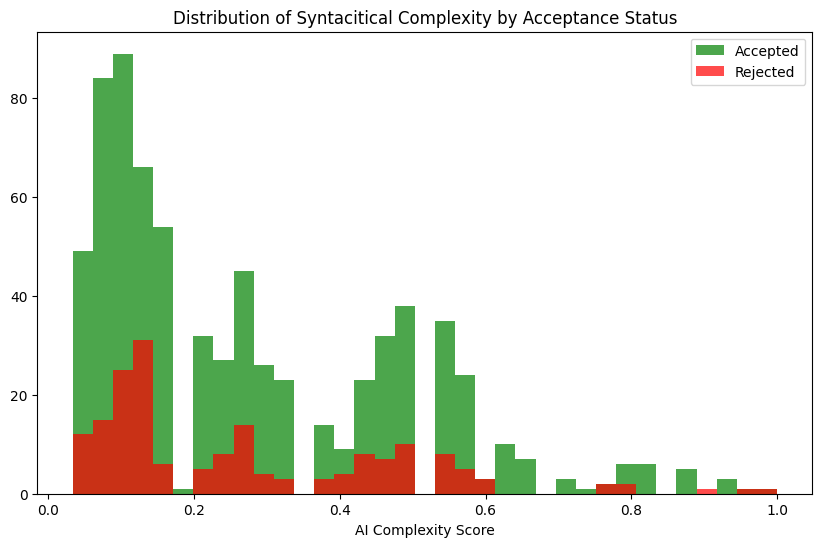

In [16]:
# plot of complexity distribution by acceptance status
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.hist(df_results_with_acceptances[df_results_with_acceptances['acceptance_status'] == 'accepted']['ai_score'], bins=35, color='green', alpha=0.7, label='Accepted')
plt.hist(df_results_with_acceptances[df_results_with_acceptances['acceptance_status'] == 'rejected']['ai_score'], bins=35, color='red', alpha=0.7, label='Rejected')
plt.title('Distribution of Syntacitical Complexity by Acceptance Status')
plt.xlabel('AI Complexity Score')
plt.legend()